### Imports

In [2]:
import time
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.sparse import hstack

from sentence_transformers import SentenceTransformer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(42)

### Load and Preprocess Data

C:\Users\Tom\AppData\Local\Temp\ipykernel_4396\2691946847.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  preprocessed_df['Headline'] = preprocessed_df['Headline'].str.replace(f'[{string.punctuation}]', '')
C:\Users\Tom\AppData\Local\Temp\ipykernel_4396\2691946847.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  preprocessed_df['ArticleBody'] = preprocessed_df['ArticleBody'].str.replace(f'[{string.punctuation}]', '')


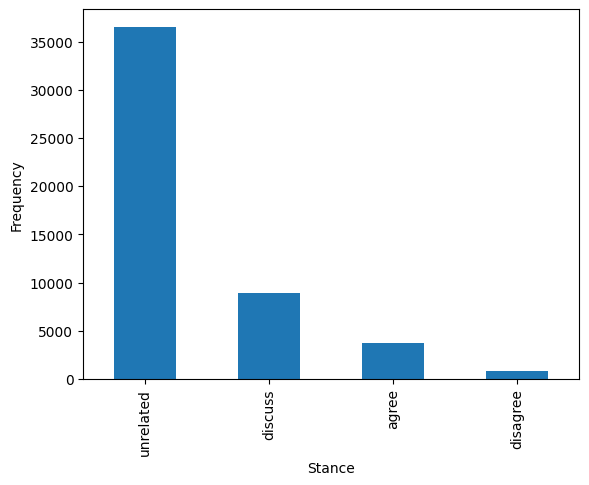

In [2]:
# Load dataframe
unprocessed_df = pd.read_csv('./train.csv')
preprocessed_df = unprocessed_df.copy()

# Plot imbalanced data
ax = unprocessed_df['Stance'].value_counts().plot.bar()
ax.set_xlabel('Stance'); ax.set_ylabel('Frequency')

# Lowercase
preprocessed_df['Headline'] = preprocessed_df['Headline'].str.lower()
preprocessed_df['ArticleBody'] = preprocessed_df['ArticleBody'].str.lower()

# Remove punctuation
preprocessed_df['Headline'] = preprocessed_df['Headline'].str.replace(f'[{string.punctuation}]', '')
preprocessed_df['ArticleBody'] = preprocessed_df['ArticleBody'].str.replace(f'[{string.punctuation}]', '')

# Remove new line \n
preprocessed_df['Headline'] = preprocessed_df['Headline'].str.replace('\n', '')
preprocessed_df['ArticleBody'] = preprocessed_df['ArticleBody'].str.replace('\n', '')

# # Remove stopwords
# preprocessed_df['Headline'] = preprocessed_df['Headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))]))
# preprocessed_df['ArticleBody'] = preprocessed_df['ArticleBody'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))]))

In [3]:
# Reserve tf-idf test set for task 3 - full pipeline
X_tf_idf_3, y_tf_idf_3 = preprocessed_df[['Headline', 'ArticleBody']], preprocessed_df['Stance']
X_train_tf_idf_3, X_test_tf_idf_3, y_train_tf_idf_3, y_test_tf_idf_3 = train_test_split(X_tf_idf_3, y_tf_idf_3, test_size=0.25, random_state=42)
preprocessed_df_train = pd.concat([X_train_tf_idf_3, y_train_tf_idf_3], axis=1)  # Train set for tasks 1 and 2

# Reserve bert test set for task 3 - full pipeline
X_bert_3, y_bert_3 = unprocessed_df[['Headline', 'ArticleBody']], unprocessed_df['Stance']
X_train_bert_3, X_test_bert_3, y_train_bert_3, y_test_bert_3 = train_test_split(X_bert_3, y_bert_3, test_size=0.25, random_state=42)
unprocessed_df_train = pd.concat([X_train_bert_3, y_train_bert_3], axis=1) # Train set for tasks 1 and 2

### Task 1 - Related/Unrelated

In [4]:
# Get only related/unrelated articles for tf-idf
preprocessed_related_unrelated_df = preprocessed_df_train.copy()
preprocessed_related_unrelated_df['Stance'].replace(['agree', 'disagree', 'discuss'], ['related', 'related', 'related'], inplace=True)

# Get only related/unrelated articles for BERT
unprocessed_related_unrelated_df = unprocessed_df_train.copy()
unprocessed_related_unrelated_df['Stance'].replace(['agree', 'disagree', 'discuss'], ['related', 'related', 'related'], inplace=True)

# Train test split data for tf-idf
X_tf_idf_1, y_tf_idf_1 = preprocessed_related_unrelated_df[['Headline', 'ArticleBody']], preprocessed_related_unrelated_df['Stance']
X_train_tf_idf_1, X_test_tf_idf_1, y_train_tf_idf_1, y_test_tf_idf_1 = train_test_split(X_tf_idf_1, y_tf_idf_1, test_size=0.25, random_state=42)

# Train test split data for BERT
X_bert_1, y_bert_1 = unprocessed_related_unrelated_df[['Headline', 'ArticleBody']], unprocessed_related_unrelated_df['Stance']
X_train_bert_1, X_test_bert_1, y_train_bert_1, y_test_bert_1 = train_test_split(X_bert_1, y_bert_1, test_size=0.25, random_state=42)

Tf-idf and BERT Feature Extraction

In [5]:
def get_tf_idf_vectoriser(X_train_tf_idf):
    # Get corpus and vocabulary
    corpus = np.concatenate([X_train_tf_idf['Headline'].to_numpy(), X_train_tf_idf['ArticleBody'].to_numpy()], axis=0)
    vocabulary = list(set([word for sentence in corpus for word in sentence.split(' ')]))

    # Fit tf-idf on train data
    vectorizer = TfidfVectorizer()
    corpus = np.concatenate([X_train_tf_idf['Headline'].to_numpy(), X_train_tf_idf['ArticleBody'].to_numpy()], axis=0)
    vectorizer.fit(corpus)

    return vectorizer

In [6]:
def get_bert_vectoriser():
    # Get pre-trained BERT model
    vectorizer = SentenceTransformer('paraphrase-MiniLM-L3-v2')

    return vectorizer

In [7]:
tf_idf_vectorizer = get_tf_idf_vectoriser(X_train_tf_idf_1)
bert_vectorizer = get_bert_vectoriser()

In [8]:
def vectorise_tf_idf(X_train_tf_idf, X_test_tf_idf, vectorizer):
    # Vectorise training/testing data (sparse csr)
    X_train_tf_idf = hstack((vectorizer.transform(X_train_tf_idf['Headline'].to_numpy()), vectorizer.transform(X_train_tf_idf['ArticleBody'].to_numpy())))
    X_test_tf_idf = hstack((vectorizer.transform(X_test_tf_idf['Headline'].to_numpy()), vectorizer.transform(X_test_tf_idf['ArticleBody'].to_numpy())))

    print('tf_idf X_train shape:\t', X_train_tf_idf.shape)
    print('tf_idf X_test shape:\t', X_test_tf_idf.shape)

    return X_train_tf_idf, X_test_tf_idf

In [9]:
def vectorise_bert(X_train_bert, X_test_bert, vectorizer):
    # Vectorise training/testing data (dense)
    X_train_bert = np.hstack((vectorizer.encode(X_train_bert['Headline'].to_numpy(), show_progress_bar=True), vectorizer.encode(X_train_bert['ArticleBody'].to_numpy(), show_progress_bar=True)))
    X_test_bert = np.hstack((vectorizer.encode(X_test_bert['Headline'].to_numpy(), show_progress_bar=True), vectorizer.encode(X_test_bert['ArticleBody'].to_numpy(), show_progress_bar=True)))

    print('bert X_train shape:\t', X_train_bert.shape)
    print('bert X_test shape:\t', X_test_bert.shape)

    return X_train_bert, X_test_bert

In [10]:
X_train_tf_idf_1, X_test_tf_idf_1 = vectorise_tf_idf(X_train_tf_idf_1, X_test_tf_idf_1, tf_idf_vectorizer)
X_train_bert_1, X_test_bert_1 = vectorise_bert(X_train_bert_1, X_test_bert_1, bert_vectorizer)

tf_idf X_train shape:	 (28109, 74214)
tf_idf X_test shape:	 (9370, 74214)


Batches: 100%|██████████| 293/293 [04:00<00:00,  1.22it/s]


bert X_train shape:	 (28109, 768)
bert X_test shape:	 (9370, 768)


ML and DL Classification

In [11]:
def esitmate_gridsearch_time(model, X_train, y_train, param_grid:dict, n_jobs:int=1, cv:int=5):
    times = []
    for _ in range(5):
        start = time.time()
        model.fit(X_train, y_train)
        model.score(X_train, y_train)
        end = time.time()
        times.append(end - start)

    single_train_time = np.array(times).mean()

    combos = 1
    for vals in param_grid.values():
        combos *= len(vals)

    num_models = combos * cv / n_jobs
    seconds = num_models * single_train_time
    minutes = seconds / 60
    hours = minutes / 60

    print(hours, minutes, seconds)

In [12]:
def hyperparameter_tuning(clf, X_train, y_train):
    if type(clf).__name__ == 'RandomForestClassifier':
        param_grid = {
            'n_estimators': [25, 50, 100],
            'max_features': ['sqrt', 'log2', None],
            'max_depth': [3, 6, 9, None],
            'max_leaf_nodes': [3, 6, 9, None]}
    elif type(clf).__name__ == 'MLPClassifier':
        param_grid = {
            'hidden_layer_sizes': [(256,), (512,), (1024,)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.001, 0.01],
            'learning_rate': ['constant','adaptive'],
            'learning_rate_init': [0.001, 0.01]}
          
    esitmate_gridsearch_time(clf, X_train, y_train, param_grid, n_jovs=1, cv=5)
    grid_search = GridSearchCV(clf, param_grid, scoring='balanced_accuracy', n_jobs=1, cv=5, verbose=1)
    grid_search.fit(X_train, y_train)

    print('Best parameters', grid_search.best_params_, 'with score', grid_search.best_score_, '\n')

    return grid_search.best_params_

In [13]:
def training_testing(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred))
    print('Balanced accuracy score:', balanced_accuracy_score(y_test, y_pred), '\n')

    return clf

In [14]:
clf_tf_idf_rfc_1 = training_testing(RandomForestClassifier(random_state=42), X_train_tf_idf_1, X_test_tf_idf_1, y_train_tf_idf_1, y_test_tf_idf_1)
clf_tf_idf_mlp_1 = training_testing(MLPClassifier(random_state=42), X_train_tf_idf_1, X_test_tf_idf_1, y_train_tf_idf_1, y_test_tf_idf_1)
clf_bert_rfc_1 = training_testing(RandomForestClassifier(random_state=42), X_train_bert_1, X_test_bert_1, y_train_bert_1, y_test_bert_1)
clf_bert_mlp_1 = training_testing(MLPClassifier(random_state=42), X_train_bert_1, X_test_bert_1, y_train_bert_1, y_test_bert_1)

              precision    recall  f1-score   support

     related       0.96      0.82      0.89      2505
   unrelated       0.94      0.99      0.96      6865

    accuracy                           0.94      9370
   macro avg       0.95      0.90      0.92      9370
weighted avg       0.94      0.94      0.94      9370

Balanced accuracy score: 0.9048761908084777 

              precision    recall  f1-score   support

     related       0.99      0.97      0.98      2505
   unrelated       0.99      0.99      0.99      6865

    accuracy                           0.99      9370
   macro avg       0.99      0.98      0.99      9370
weighted avg       0.99      0.99      0.99      9370

Balanced accuracy score: 0.9834787816937138 

              precision    recall  f1-score   support

     related       0.99      0.85      0.92      2505
   unrelated       0.95      1.00      0.97      6865

    accuracy                           0.96      9370
   macro avg       0.97      0.92   

### Task 2 - Agree/Disagree/Discuss

In [15]:
# Get only related articles for tf-idf
preprocessed_related_df = preprocessed_df_train.copy()
preprocessed_related_df = preprocessed_related_df[preprocessed_related_df['Stance'] != 'unrelated']

# Get only related/unrelated articles for bert
unprocessed_related_df = unprocessed_df_train.copy()
unprocessed_related_df = unprocessed_related_df[unprocessed_related_df['Stance'] != 'unrelated']

# Train test split data for tf-idf
X_tf_idf_2, y_tf_idf_2 = preprocessed_related_df[['Headline', 'ArticleBody']], preprocessed_related_df['Stance']
X_train_tf_idf_2, X_test_tf_idf_2, y_train_tf_idf_2, y_test_tf_idf_2 = train_test_split(X_tf_idf_2, y_tf_idf_2, test_size=0.25, random_state=42)

# Train test split data for BERT
X_bert_2, y_bert_2 = unprocessed_related_df[['Headline', 'ArticleBody']], unprocessed_related_df['Stance']
X_train_bert_2, X_test_bert_2, y_train_bert_2, y_test_bert_2 = train_test_split(X_bert_2, y_bert_2, test_size=0.25, random_state=42)

In [16]:
X_train_tf_idf_2, X_test_tf_idf_2 = vectorise_tf_idf(X_train_tf_idf_2, X_test_tf_idf_2, tf_idf_vectorizer)
X_train_bert_2, X_test_bert_2 = vectorise_bert(X_train_bert_2, X_test_bert_2, bert_vectorizer)

tf_idf X_train shape:	 (7548, 74214)
tf_idf X_test shape:	 (2516, 74214)


Batches: 100%|██████████| 79/79 [01:10<00:00,  1.13it/s]


bert X_train shape:	 (7548, 768)
bert X_test shape:	 (2516, 768)


In [17]:
clf_tf_idf_rfc_2 = training_testing(RandomForestClassifier(random_state=42), X_train_tf_idf_2, X_test_tf_idf_2, y_train_tf_idf_2, y_test_tf_idf_2)
clf_tf_idf_mlp_2 = training_testing(MLPClassifier(random_state=42), X_train_tf_idf_2, X_test_tf_idf_2, y_train_tf_idf_2, y_test_tf_idf_2)

clf_bert_rfc_2 = training_testing(RandomForestClassifier(random_state=42), X_train_bert_2, X_test_bert_2, y_train_bert_2, y_test_bert_2)
clf_bert_mlp_2 = training_testing(MLPClassifier(random_state=42), X_train_bert_2, X_test_bert_2, y_train_bert_2, y_test_bert_2)

              precision    recall  f1-score   support

       agree       0.75      0.73      0.74       725
    disagree       0.52      0.43      0.47       129
     discuss       0.89      0.91      0.90      1662

    accuracy                           0.83      2516
   macro avg       0.72      0.69      0.70      2516
weighted avg       0.83      0.83      0.83      2516

Balanced accuracy score: 0.6874662495243297 

              precision    recall  f1-score   support

       agree       0.92      0.92      0.92       725
    disagree       0.71      0.73      0.72       129
     discuss       0.98      0.98      0.98      1662

    accuracy                           0.95      2516
   macro avg       0.87      0.87      0.87      2516
weighted avg       0.95      0.95      0.95      2516

Balanced accuracy score: 0.8744950914686221 

              precision    recall  f1-score   support

       agree       0.86      0.77      0.81       725
    disagree       0.76      0.46    

In [18]:
# # Hyperparameter tune for balanced accuracy (only bert as tf-idf too time expensive)
# clf_bert_rfc_params_2 = hyperparameter_tuning(RandomForestClassifier(random_state=42), X_train_bert_2, y_train_bert_2)
# clf_bert_mlp_params_2 = hyperparameter_tuning(MLPClassifier(random_state=42), X_train_bert_2, y_train_bert_2)

# clf_bert_rfc_tuned_2 = training_testing(RandomForestClassifier(**clf_bert_mlp_params_2), X_train_bert_2, X_test_bert_2, y_train_bert_2, y_test_bert_2)
# clf_bert_mlp_tuned_2 = training_testing(MLPClassifier(**clf_bert_mlp_params_2), X_train_bert_2, X_test_bert_2, y_train_bert_2, y_test_bert_2)

Custom MLP Classification

In [19]:
class Data(Dataset):
  def __init__(self, X_train, y_train):
    self.X = X_train
    self.y = y_train
    self.len = self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]
    
  def __len__(self):
    return self.len


class Network(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim):
    super(Network, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    self.fc3 = nn.Linear(hidden_dim, output_dim)
    self.droput = nn.Dropout(0.2)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.droput(x)
    x = F.relu(self.fc2(x))
    x = self.droput(x)
    x = self.fc3(x)

    return x

In [20]:
def training_testing_custom(X_train, X_test, y_train, y_test):   
    input_dim = X_train.shape[1]
    output_dim = len(y_train.unique())
    hidden_layers = 512
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.numpy())
    class_weights = torch.FloatTensor(class_weights)

    clf = Network(input_dim, output_dim, hidden_layers)
    criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
    optimizer = optim.Adam(clf.parameters())

    training_data = Data(X_train, y_train)
    training_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

    epochs = 150
    for epoch in tqdm(range(epochs)):
        # Training
        for data in training_dataloader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = clf(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # # Testing
        # with torch.no_grad():
        #     outputs = clf(X_test)
        #     __, y_pred = torch.max(outputs.data, 1)
        #     print(epoch, balanced_accuracy_score(y_test, y_pred))
    
    with torch.no_grad():
        outputs = clf(X_test)
        __, y_pred = torch.max(outputs.data, 1)
    print(classification_report(y_test, y_pred))
    print('Balanced accuracy score:', balanced_accuracy_score(y_test, y_pred))

    return clf

In [21]:
# Convert tf-idf to tensors
X_train_tf_idf_2_tensor = torch.FloatTensor(X_train_tf_idf_2.todense())
X_test_tf_idf_2_tensor = torch.FloatTensor(X_test_tf_idf_2.todense())
y_train_tf_idf_2_tensor = torch.LongTensor(y_train_tf_idf_2.map({'agree': 0, 'disagree': 1, 'discuss': 2}).to_numpy())
y_test_tf_idf_2_tensor = torch.LongTensor(y_test_tf_idf_2.map({'agree': 0, 'disagree': 1, 'discuss': 2}).to_numpy())

# Convert bert to tensors
X_train_bert_2_tensor = torch.FloatTensor(X_train_bert_2)
X_test_bert_2_tensor = torch.FloatTensor(X_test_bert_2)
y_train_bert_2_tensor = torch.LongTensor(y_train_bert_2.map({'agree': 0, 'disagree': 1, 'discuss': 2}).to_numpy())
y_test_bert_2_tensor = torch.LongTensor(y_test_bert_2.map({'agree': 0, 'disagree': 1, 'discuss': 2}).to_numpy())

In [22]:
# Custom deep learning multi-class classifier
clf_tf_idf_mlp_custom_2 = training_testing_custom(X_train_tf_idf_2_tensor, X_test_tf_idf_2_tensor, y_train_tf_idf_2_tensor, y_test_tf_idf_2_tensor)
clf_bert_mlp_custom_2 = training_testing_custom(X_train_bert_2_tensor, X_test_bert_2_tensor, y_train_bert_2_tensor, y_test_bert_2_tensor)

100%|██████████| 150/150 [3:34:42<00:00, 85.89s/it]  


              precision    recall  f1-score   support

           0       0.90      0.94      0.92       725
           1       0.77      0.77      0.77       129
           2       0.98      0.97      0.97      1662

    accuracy                           0.95      2516
   macro avg       0.88      0.89      0.89      2516
weighted avg       0.95      0.95      0.95      2516

Balanced accuracy score: 0.8910779340131518


100%|██████████| 150/150 [05:08<00:00,  2.06s/it]

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       725
           1       0.68      0.78      0.72       129
           2       0.97      0.94      0.95      1662

    accuracy                           0.93      2516
   macro avg       0.84      0.88      0.86      2516
weighted avg       0.93      0.93      0.93      2516

Balanced accuracy score: 0.878141214003862


### Task 3 - Full Pipeline

In [23]:
# Vectorise w.r.t tf_idf and bert
X_train_tf_idf_3, X_test_tf_idf_3 = vectorise_tf_idf(X_train_tf_idf_3, X_test_tf_idf_3, tf_idf_vectorizer)
X_train_bert_3, X_test_bert_3 = vectorise_bert(X_train_bert_3, X_test_bert_3, bert_vectorizer)

tf_idf X_train shape:	 (37479, 74214)
tf_idf X_test shape:	 (12493, 74214)


Batches: 100%|██████████| 391/391 [05:50<00:00,  1.11it/s]


bert X_train shape:	 (37479, 768)
bert X_test shape:	 (12493, 768)


In [24]:
def full_pipeline(clf_1, clf_2, X_test_clf_1, y_test_clf_1, x_test_clf_2, y_test_clf_2):
    # Predict related/unrelated label
    task_1_y_pred = clf_1.predict(X_test_clf_1)

    # Get only the related predictions from task 1
    X_test_subset = [np.squeeze(np.asarray(a)) for a, b in zip(x_test_clf_2.todense(), task_1_y_pred) if b != 'unrelated']

    # Predict related label
    task_2_y_pred = iter(torch.max(clf_2(torch.FloatTensor(X_test_subset)), 1)[1].detach().numpy())

    # Combine task 1 and 2 predictions
    task_3_y_pred = [task_1_pred if task_1_pred == 'unrelated' else next(task_2_y_pred) for task_1_pred in task_1_y_pred]

    # Un-map numerical classes
    task_3_y_pred = pd.Series(task_3_y_pred).map({0:'agree', 1:'disagree', 2:'discuss', 'unrelated':'unrelated'}).to_numpy()

    # Scoring
    print(classification_report(y_test_clf_1, task_3_y_pred))
    print('Balanced accuracy score:', balanced_accuracy_score(y_test_clf_1, task_3_y_pred), '\n')

In [25]:
full_pipeline(clf_bert_mlp_1, clf_tf_idf_mlp_custom_2, X_test_bert_3, y_test_bert_3, X_test_tf_idf_3, y_test_tf_idf_3)

C:\Users\Tom\AppData\Local\Temp\ipykernel_4396\3966589249.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  task_2_y_pred = iter(torch.max(clf_2(torch.FloatTensor(X_test_subset)), 1)[1].detach().numpy())


              precision    recall  f1-score   support

       agree       0.87      0.92      0.89       910
    disagree       0.79      0.77      0.78       230
     discuss       0.97      0.96      0.97      2223
   unrelated       1.00      0.99      1.00      9130

    accuracy                           0.98     12493
   macro avg       0.91      0.91      0.91     12493
weighted avg       0.98      0.98      0.98     12493

Balanced accuracy score: 0.9110864945236757 

